# Install missing packages

In [1]:
!pip install scanpy torchdiffeq torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1

# Imports

In [2]:
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Reconstruct selected genes + adjacency mask

In [4]:
import scanpy as sc

adata = sc.read_h5ad("Sergio_filtered.h5ad")
adata.var_names_make_unique()
print("Loaded shape:", adata.shape)

Loaded shape: (5067, 3180)


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
print("Initial n_cells:", X.shape[0])

Initial n_cells: 5067


In [6]:
# (1) Convert .X to dense and inspect
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
print("X min:", np.nanmin(X), "X max:", np.nanmax(X))

# (2) Check if it's already log-transformed
is_log = np.nanmax(X) < 30 and np.nanmin(X) > -5
print("Is log:", is_log)

# (3) Remove only rows with NaNs (don’t filter zeros yet!)
valid = ~np.isnan(X).any(axis=1)
adata = adata[valid].copy()
print("After NaN filter:", adata.shape)

X min: 0.0 X max: 608.0
Is log: False
After NaN filter: (5067, 3180)


In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Compute Pseudotime

In [8]:
root_cell = adata.obs_names[np.argmin(adata.obsm['X_umap'][:, 0])]
adata.uns["iroot"] = np.flatnonzero(adata.obs_names == root_cell)[0]
sc.tl.diffmap(adata, n_comps=10)
sc.tl.dpt(adata, n_dcs=10)

In [9]:
adata = adata[~adata.obs['dpt_pseudotime'].isna()].copy()
adata.obs['time_bin'] = pd.qcut(
    adata.obs['dpt_pseudotime'], q=5, labels=False, duplicates='drop'
)

In [10]:
adata.write("Sergio_subset_pseudotime.h5ad")

# Prepare gene list / adj mask

In [11]:
import pandas as pd
import numpy as np

# reload DoRothEA and TFs
dorothea_df = pd.read_csv("dorothea_hs.csv")
tf_list = [line.strip() for line in open("TF_list.txt") if line.strip()]

# filter to genes present in AnnData
valid_genes = set(adata.var_names)
filtered_df = dorothea_df[
    dorothea_df["tf"].isin(tf_list) & dorothea_df["tf"].isin(valid_genes) &
    dorothea_df["target"].isin(valid_genes)
]

# create ordered gene list
selected_genes = sorted(set(filtered_df["tf"]) | set(filtered_df["target"]))
pd.Series(selected_genes).to_csv("selected_genes.csv", index=False)

# create adjacency mask
gene_to_idx = {g: i for i, g in enumerate(selected_genes)}
adj_mask = np.zeros((len(selected_genes), len(selected_genes)), dtype=np.float32)

for _, row in filtered_df.iterrows():
    i = gene_to_idx[row["tf"]]
    j = gene_to_idx[row["target"]]
    adj_mask[i, j] = 1.0

np.save("adjacency_mask.npy", adj_mask)

# Load everything into pipeline

In [12]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch

adta = sc.read_h5ad("Sergio_subset_pseudotime.h5ad")
gene_list = pd.read_csv("selected_genes.csv").iloc[:, 0].tolist()
adjacency_mask = np.load("adjacency_mask.npy")
edge_index = torch.tensor(np.array(np.nonzero(adjacency_mask)), dtype=torch.long)

# Create PyTorch dataset

In [13]:
from torch.utils.data import Dataset, DataLoader

class GRNGraphDataset(torch.utils.data.Dataset):
    def __init__(self, adata, gene_list, edge_index):
        self.adata = adata[:, gene_list]
        self.edge_index = edge_index
        self.X = self.adata.X.toarray() if not isinstance(self.adata.X, np.ndarray) else self.adata.X
        self.t = self.adata.obs['dpt_pseudotime'].values.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(1)  # shape: [num_genes, 1]
        edge_index = self.edge_index
        t = torch.tensor(self.t[idx], dtype=torch.float32)
        return Data(x=x, edge_index=edge_index, t=t)

# Define the GNN-ODE model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torchdiffeq import odeint

class GATEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.gat = GATConv(in_dim, hidden_dim)

    def forward(self, x, edge_index):
        return F.relu(self.gat(x, edge_index))

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Tanh(),
            nn.Linear(dim, dim)
        )

    def forward(self, t, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, h):
        return self.fc(h)

class GNN_ODE_Model(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.encoder = GATEncoder(in_dim, hidden_dim)
        self.odefunc = ODEFunc(hidden_dim)
        self.decoder = Decoder(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, t = data.x, data.edge_index, data.t
        h0 = self.encoder(x, edge_index)
        # Ensure t is strictly greater than 0.0
        t = t + 1e-5 if t == 0.0 else t
        t_span = torch.tensor([0.0, t], device=x.device)
        ht = odeint(self.odefunc, h0, t_span)
        return self.decoder(ht[-1])  # shape: [num_genes, 1]


# Initialize datset + dataloader

In [15]:
from torch_geometric.loader import DataLoader

dataset = GRNGraphDataset(adta, gene_list, edge_index)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Train !

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN_ODE_Model(in_dim=1, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        x_true = batch.x
        optimizer.zero_grad()
        x_pred = model(batch)
        loss = F.mse_loss(x_pred, x_true)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

loss = train(model, dataloader, optimizer, device)
print(f"Epoch 1 Loss: {loss:.4f}")

100%|██████████| 5067/5067 [26:01<00:00,  3.24it/s]

Epoch 1 Loss: 0.3683


# We're just gonna do subset training due to compute constraints.

100%|██████████| 500/500 [03:30<00:00,  2.37it/s]


Epoch 2 Loss: 0.3227


100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


Epoch 3 Loss: 0.3204


100%|██████████| 500/500 [03:41<00:00,  2.25it/s]


Epoch 4 Loss: 0.3187


100%|██████████| 500/500 [03:42<00:00,  2.24it/s]


Epoch 5 Loss: 0.3182


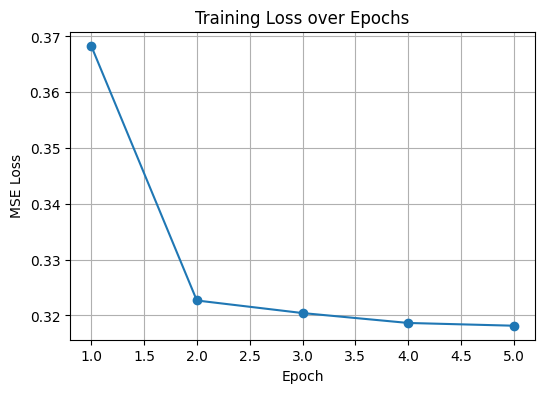

In [ ]:
import numpy as np
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# subset 500 random cells from the original dataset
subset_indices = np.random.choice(len(dataset), size=500, replace=False)
subset = Subset(dataset, subset_indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=True)

# initialize list and store first loss from earlier training
losses = [loss]  # assuming `loss` from epoch 1 already exists

# continue training and log loss
for epoch in range(2, 6):  # epochs 2–5 on subset
    loss = train(model, subset_loader, optimizer, device)
    losses.append(loss)
    print(f"Epoch {epoch} Loss: {loss:.4f}")

# plot loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

# Training a little more

100%|██████████| 500/500 [03:53<00:00,  2.14it/s]


Epoch 6 Loss: 0.3262


100%|██████████| 500/500 [04:04<00:00,  2.05it/s]


Epoch 7 Loss: 0.3244


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


Epoch 8 Loss: 0.3225


100%|██████████| 500/500 [04:23<00:00,  1.90it/s]


Epoch 9 Loss: 0.3219


100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


Epoch 10 Loss: 0.3220


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


Epoch 11 Loss: 0.3207


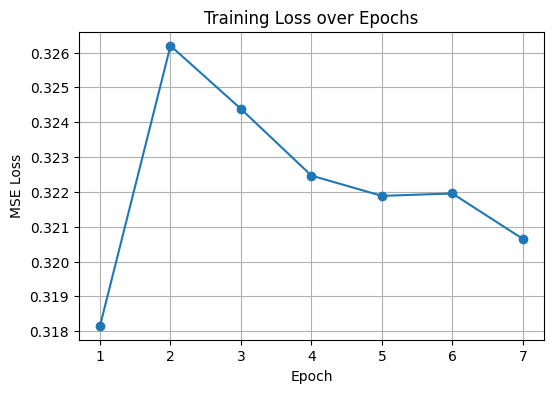

In [ ]:
# subset 500 random cells from the original dataset
subset_indices = np.random.choice(len(dataset), size=500, replace=False)
subset = Subset(dataset, subset_indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=True)

# initialize list and store first loss from earlier training
losses = [loss]  # assuming `loss` from epoch 1 already exists

# continue training and log loss
for epoch in range(6, 12):  # epochs 2–5 on subset
    loss = train(model, subset_loader, optimizer, device)
    losses.append(loss)
    print(f"Epoch {epoch} Loss: {loss:.4f}")

# plot loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "gnn_ode_model.pth")

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
    'epoch': 5,
}, "gnn_ode_checkpoint.pth")


# Overall reconstruction performance

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            x_pred = model(batch)
            x_true = batch.x
            total_loss += F.mse_loss(x_pred, x_true).item()
    return total_loss / len(dataloader)

val_loss = evaluate(model, dataloader, device)
print(f"Validation Loss (MSE): {val_loss:.4f}")

Validation Loss (MSE): 0.3213


# Error vs. Pseudotime

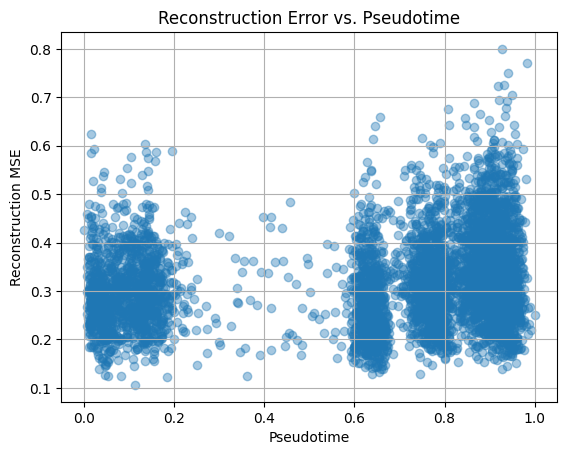

In [ ]:
import matplotlib.pyplot as plt

errors = []
pseudotimes = []

model.eval()
with torch.no_grad():
    for batch in dataset:
        x_true = batch.x
        x_pred = model(batch.to(device)).cpu()
        mse = F.mse_loss(x_pred, x_true).item()
        errors.append(mse)
        pseudotimes.append(batch.t.item())

plt.scatter(pseudotimes, errors, alpha=0.4)
plt.xlabel("Pseudotime")
plt.ylabel("Reconstruction MSE")
plt.title("Reconstruction Error vs. Pseudotime")
plt.grid(True)
plt.show()

# Visualize predictions for one cell

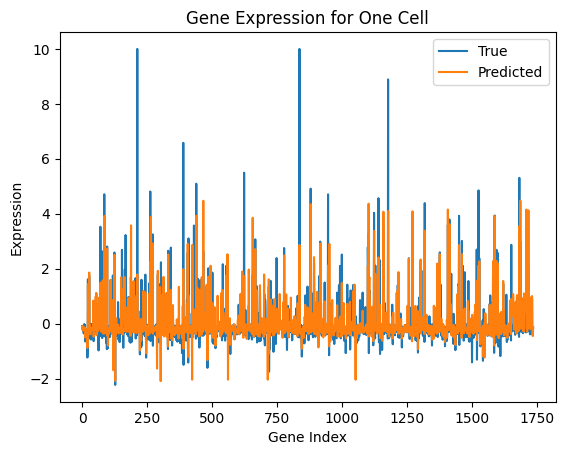

In [ ]:
sample = dataset[0].to(device)
with torch.no_grad():
    x_pred = model(sample).cpu().numpy().flatten()
    x_true = sample.x.cpu().numpy().flatten()

plt.plot(x_true, label='True')
plt.plot(x_pred, label='Predicted')
plt.title("Gene Expression for One Cell")
plt.xlabel("Gene Index")
plt.ylabel("Expression")
plt.legend()
plt.show()

## Validation

# Compare learned TF-target attention to ground truth

Compare learned attention scores from the GAT to the true regulatory edges from DoRothEA. The steps to do this are (1) extract attention weights from the GAT layer, (2) average those scores across many cells, (3) compare top predited TF-target edges to the known ones in dorothea_hs.csv, (4) compute overlap and optionally AUPRC or Precision@k

In [16]:
# ---------------- core ----------------
import warnings

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# ---------------- single-cell ----------------
import scanpy as sc

# ---------------- graph & ODE ----------------
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torchdiffeq import odeint

# ---------------- metrics ----------------
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
)

# ---------------- scientific utils ----------------
from scipy.linalg import svd
from scipy.ndimage import gaussian_filter1d
from scipy.cluster.hierarchy import linkage, leaves_list

device = "cuda" if torch.cuda.is_available() else "cpu"

# 2.1  expression & pseudotime
adata = sc.read_h5ad("Sergio_subset_pseudotime.h5ad")
X    = adata[:, gene_list].X.toarray()
tvec = adata.obs["dpt_pseudotime"].astype("float32").values
# 2.2  fixed edge list
adj   = np.load("adjacency_mask.npy")
edge_index = torch.tensor(np.nonzero(adj), dtype=torch.long)

class InferenceDataset(Dataset):
    def __len__(self):  return X.shape[0]
    def __getitem__(self, idx):
        return Data(
            x=torch.tensor(X[idx], dtype=torch.float32).unsqueeze(1),
            edge_index=edge_index,
            t=torch.tensor(tvec[idx])
        )
dset = InferenceDataset()
loader = DataLoader(dset, batch_size=1, shuffle=False)

# ----------------  building blocks ----------------
class Encoder(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.gat = GATConv(1, hidden, heads=1,
                           concat=False, add_self_loops=False)
    def forward(self, x, edge_index, return_attn=False):
        h, (edge_i, α) = self.gat(x, edge_index,
                                  return_attention_weights=True)
        h = torch.relu(h)
        return (h, α) if return_attn else (h, None)

class ODEFunc(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden)
        )
    def forward(self, t, h):
        return self.net(h)

class Decoder(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.fc = nn.Linear(hidden, 1)
    def forward(self, h):
        return self.fc(h)

# ----------------  wrapper model ------------------
class GNN_ODE_Model(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.encoder = Encoder(hidden)
        self.odefunc = ODEFunc(hidden)
        self.decoder = Decoder(hidden)

    def forward(self, data, return_attn=False):
        h0, α = self.encoder(data.x, data.edge_index, return_attn=True)
        tspan = torch.tensor([0., data.t.item() + 1e-5],
                             device=data.x.device)
        hT = odeint(self.odefunc, h0, tspan,
                    rtol=1e-3, atol=1e-4)[-1]
        out = self.decoder(hT)
        return (out, α) if return_attn else out


device = "cuda" if torch.cuda.is_available() else "cpu"

model = GNN_ODE_Model(hidden=32).to(device)
state = torch.load("gnn_ode_model.pth", map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

<ipython-input-16-c9d2316ba750>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(np.nonzero(adj), dtype=torch.long)


GNN_ODE_Model(
  (encoder): Encoder(
    (gat): GATConv(1, 32, heads=1)
  )
  (odefunc): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
print("All weights loaded!")
print(list(state.keys())[:5])

All weights loaded!
['encoder.gat.att_src', 'encoder.gat.att_dst', 'encoder.gat.bias', 'encoder.gat.lin.weight', 'odefunc.net.0.weight']


In [18]:
data = next(iter(loader)).to(device)
with torch.no_grad():
    ŷ, α = model(data, return_attn=True)
print(ŷ.shape)
print(α.shape)

torch.Size([1736, 1])
torch.Size([3680, 1])


In [19]:
num_genes = loader.dataset[0].x.shape[0]
cell_mse  = []
gene_mse  = np.zeros(num_genes)

with torch.no_grad():
    for batch in loader:
        y_hat = model(batch.to(device), return_attn=False)
        y_true = batch.x.to(device)
        err = (y_hat - y_true).cpu().numpy()[:, 0]
        cell_mse.append(np.mean(err**2))
        gene_mse += err**2

gene_mse /= len(loader)
print(f"Global MSE: {np.mean(cell_mse):.4f}")

Global MSE: 1.9919


In [20]:
gene_mean = X.mean(axis=0, keepdims=True)
baseline_mse = ((X - gene_mean)**2).mean()
print(baseline_mse)

0.86405516


In [21]:
worst = np.argsort(-gene_mse)[:10]
for i in worst:
    print(selected_genes[i], gene_mse[i])

PGK1 4.992015741080059
PGAM1 4.842280833881692
FAM162A 4.810903143715624
CCKBR 4.746585780045376
CD63 4.635608452534688
FHL1 4.625573003080227
PFKFB4 4.616737251796769
ATF4 4.599891386547331
KDM3A 4.591530170913632
GYS1 4.574495373859035


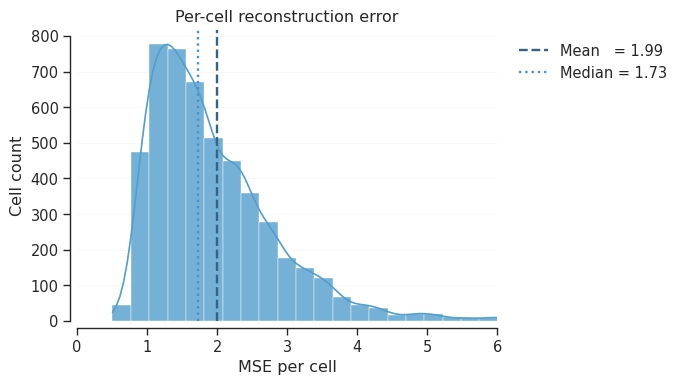

In [22]:

sns.set_theme(context="paper", style="ticks", font_scale=1.2)

# basic stats
mean_mse   = np.mean(cell_mse)
median_mse = np.median(cell_mse)
p95        = np.percentile(cell_mse, 95)

sns.set_theme(context="paper", style="ticks", font_scale=1.2)

mean_mse   = np.mean(cell_mse)
median_mse = np.median(cell_mse)

hist_color   = sns.color_palette("Blues_r")[2]
mean_color   = sns.color_palette("Blues_d")[4]
median_color = sns.color_palette("Blues_d")[2]

plt.figure(figsize=(7, 4))
ax = sns.histplot(
    cell_mse, bins=40, stat="count",
    color=hist_color, edgecolor="white", linewidth=0.3,
    alpha=0.8, kde=True, kde_kws=dict(bw_adjust=0.7, cut=0)
)
ax.axvline(mean_mse,   ls="--", lw=1.7, color=mean_color,
           label=f"Mean   = {mean_mse:.2f}")
ax.axvline(median_mse, ls=":",  lw=1.7, color=median_color,
           label=f"Median = {median_mse:.2f}")

ax.set(
    title="Per-cell reconstruction error",
    xlabel="MSE per cell",
    ylabel="Cell count",
    xlim=(0, 6)
)
sns.despine(offset=5, trim=True)
ax.grid(axis="y", alpha=0.15)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [23]:

tvec = np.array([b.t.item() for b in loader])

# plt.scatter(tvec, cell_mse, s=8)
# plt.xlabel("pseudotime"); plt.ylabel("MSE per cell"); plt.show()

ρ, p = st.spearmanr(tvec, cell_mse)
print(f"Spearman ρ = {ρ:.3f}  (p={p:.1e})")

Spearman ρ = 0.165  (p=2.4e-32)


In [24]:
# ------------------------------------------------------------------
#  Reverse-edge evaluation  (target ➜ TF)
#  • extracts attention weights on the flipped edge list
#  • computes y_true, AUROC, AUPRC
#  • plots histogram of attention scores for pos vs neg
# ------------------------------------------------------------------


gene_df = pd.read_csv("selected_genes.csv", header=None)   # any delimiter
gene_list = gene_df.iloc[:, 0].astype(str).tolist()

# if the first entry is just an index like "0", drop it
if gene_list[0].isdigit():
    gene_list = gene_list[1:]

N = len(gene_list)
gene_to_idx = {g: i for i, g in enumerate(gene_list)}
print(f"{N} genes loaded")
import numpy as np, pandas as pd

dorothea = pd.read_csv("dorothea_hs.csv")
df = dorothea[dorothea.tf.isin(gene_to_idx) & dorothea.target.isin(gene_to_idx)]

adj_mask = np.zeros((N, N), dtype=np.uint8)
for tf, tgt in zip(df.tf, df.target):
    adj_mask[gene_to_idx[tf], gene_to_idx[tgt]] = 1

print("positive edges in mask:", adj_mask.sum())
y_true = adj_mask[edge_index[0], edge_index[1]]
print("unique labels in y_true:", np.unique(y_true, return_counts=True))



1736 genes loaded
positive edges in mask: 10902
unique labels in y_true: (array([1], dtype=uint8), array([3680]))


reverse AUROC: 0.5701827242524917
reverse AUPRC: 0.023677263703940212


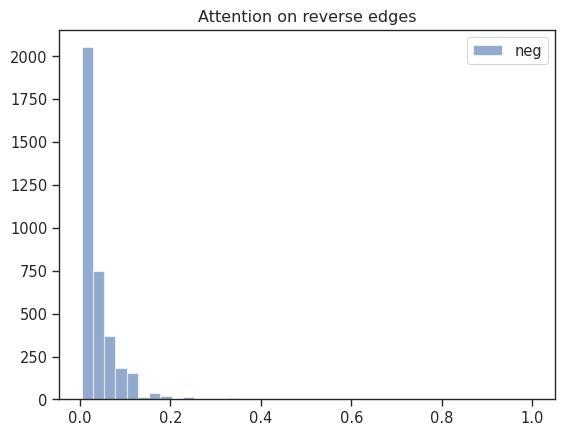

In [25]:
# 1. Build reverse edge list
rev_edge_index = torch.stack([edge_index[1], edge_index[0]])   # dst→src

# 2. Run once to get attention on those reverse edges
edge_scores_rev = torch.zeros(rev_edge_index.shape[1])

with torch.no_grad():
    for batch in loader:
        batch.edge_index = rev_edge_index
        batch = batch.to(device)
        _, α = model(batch, return_attn=True)
        edge_scores_rev += α.squeeze().cpu()

edge_scores_rev /= len(loader)

# 3. Labels in reverse direction
y_true_rev = adj_mask[rev_edge_index[0], rev_edge_index[1]]

from sklearn.metrics import roc_auc_score, average_precision_score
print("reverse AUROC:", roc_auc_score(y_true_rev, edge_scores_rev))
print("reverse AUPRC:", average_precision_score(y_true_rev, edge_scores_rev))

# sanity plot
import matplotlib.pyplot as plt, numpy as np
plt.hist(edge_scores_rev[y_true_rev==0], 40, alpha=.6, label="neg")
plt.legend(); plt.title("Attention on reverse edges"); plt.show()


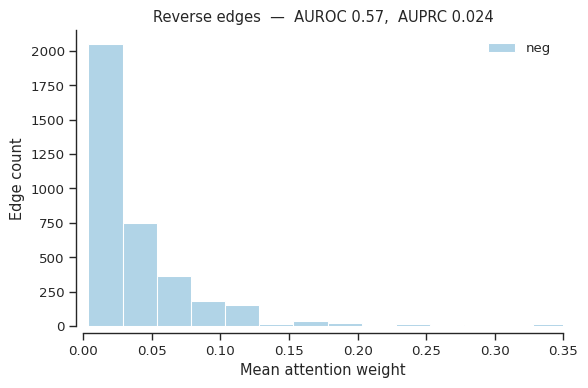

In [26]:

sns.set_theme(context="paper", style="ticks", font_scale=1.1)

plt.figure(figsize=(6,4))
sns.histplot(edge_scores_rev[y_true_rev==0], bins=40, color="#9ecae1", alpha=.8, label="neg")
plt.xlim(0, 0.35)                # zoom where the mass is
plt.xlabel("Mean attention weight")
plt.ylabel("Edge count")
plt.title(f"Reverse edges  —  AUROC {roc_auc_score(y_true_rev, edge_scores_rev):.2f},  AUPRC {average_precision_score(y_true_rev, edge_scores_rev):.3f}")
plt.legend(frameon=False)
sns.despine(offset=5)
plt.tight_layout()
plt.show()


Precision@25  = 23/25  (0.920)
Precision@50  = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)


<ipython-input-66-3dcf21eba729>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(k) for k in K_list], y=precision, palette="Blues_d")


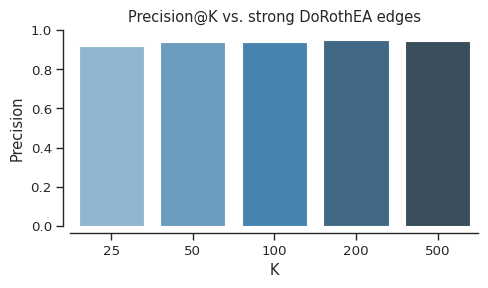

In [66]:

if 'edge_scores' not in globals():
    print("Rebuilding (forward edges)…")
    edge_scores_raw = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            _, alpha = model(batch, return_attn=True)   # alpha shape (E,1)
            edge_scores_raw.append(alpha.squeeze().cpu())

    edge_scores = torch.stack(edge_scores_raw, dim=0).mean(dim=0).numpy()
    print("edge_scores rebuilt.")

# ── Load strong DoRothEA TF-target pairs once ────────────────
if 'strong_pairs' not in globals():
    doro = pd.read_csv("dorothea_hs.csv")
    tf_set = set(open("TF_list.txt").read().split())
    strong = doro[doro.confidence.isin(["A", "B", "C"])]
    strong_pairs = {(gene_to_idx[tf], gene_to_idx[tg])
                    for tf, tg in zip(strong.tf, strong.target)
                    if tf in gene_to_idx and tg in gene_to_idx}

# ── Precision@K and bar plot (single pass) ───────────────────
order = np.argsort(-edge_scores)               # highest attention first
K_list = [25, 50, 100, 200, 500]
precision = []

for K in K_list:
    top_pairs = {(edge_index[0, i].item(), edge_index[1, i].item())
                 for i in order[:K]}
    hits = len(top_pairs & strong_pairs)
    precision.append(hits / K)
    print(f"Precision@{K:<3d} = {hits}/{K}  ({hits/K:.3f})")

sns.set_theme(context="paper", style="ticks", font_scale=1.1)
plt.figure(figsize=(5, 3))
sns.barplot(x=[str(k) for k in K_list], y=precision, palette="Blues_d")
plt.ylim(0, 1)
plt.ylabel("Precision")
plt.xlabel("K")
plt.title("Precision@K vs. strong DoRothEA edges")
sns.despine(offset=5)
plt.tight_layout()
plt.show()



Label balance  →  positives: 2848  negatives: 832
Precision@25  = 23/25  (0.920)
Precision@50  = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)

AUPRC (A/B vs. rest) = 0.870


<ipython-input-28-89715d77b2ad>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(k) for k in K_list],


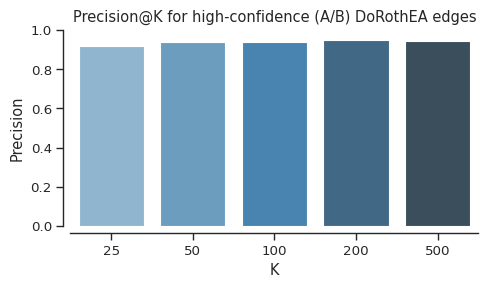

In [28]:
# ╔════════════ 1. Build ground-truth labels (A/B = positive) ═══════════╗

# set of strong (A or B) TF→target index pairs
strong_pairs = {(gene_to_idx[tf], gene_to_idx[tg])
                for tf, tg, conf in zip(doro.tf, doro.target, doro.confidence)
                if conf in ["A", "B"] and tf in gene_to_idx and tg in gene_to_idx}

# y_true: 1 if strong (A/B), 0 otherwise
y_true_strong = np.array([
    1 if (edge_index[0,i].item(), edge_index[1,i].item()) in strong_pairs else 0
    for i in range(edge_index.size(1))
])

print("Label balance  →  positives:",
      y_true_strong.sum(), " negatives:", (1-y_true_strong).sum())



# ╔════════════ 2. Precision@K & AUPRC on these labels ═════════════════╗
order = np.argsort(-edge_scores)          # descending attention
K_list = [25, 50, 100, 200, 500]
precision = []

for K in K_list:
    hits = y_true_strong[order[:K]].sum()
    precision.append(hits / K)
    print(f"Precision@{K:<3d} = {hits}/{K}  ({hits/K:.3f})")

auprc = average_precision_score(y_true_strong, edge_scores)
print(f"\nAUPRC (A/B vs. rest) = {auprc:.3f}")

# bar-plot

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
sns.set_theme(context="paper", style="ticks", font_scale=1.1)
plt.figure(figsize=(5,3))
sns.barplot(x=[str(k) for k in K_list],
            y=precision,
            palette="Blues_d",
            legend=False)
plt.ylim(0,1)
plt.ylabel("Precision"); plt.xlabel("K")
plt.title("Precision@K for high-confidence (A/B) DoRothEA edges")
sns.despine(offset=5); plt.tight_layout(); plt.show()
# ╚══════════════════════════════════════════════════════════════════════╝

plt.show()

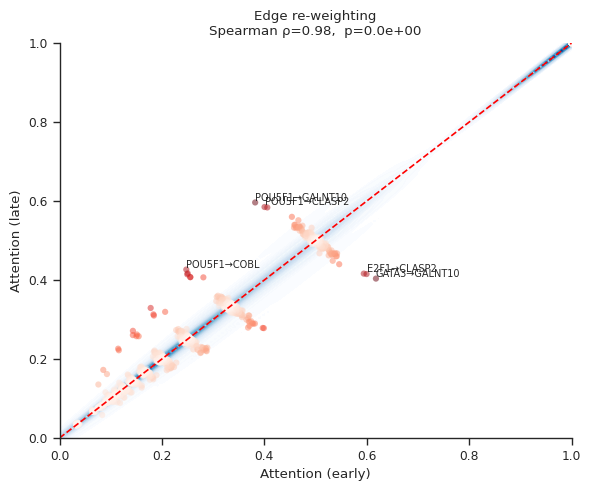

In [29]:

# ── 1. split cells by pseudotime ─────────────────────────────────────────
mid = np.median(tvec)
early_idx = np.where(tvec <= mid)[0]
late_idx  = np.where(tvec >  mid)[0]

def mean_att(cell_indices):
    """Average attention over a list of cell indices."""
    s = torch.zeros(edge_index.size(1))
    with torch.no_grad():
        for i in cell_indices:
            batch = dataset[i].to(device)
            _, alpha = model(batch, return_attn=True)  # alpha: (E,1)
            s += alpha.squeeze().cpu()
    return (s / len(cell_indices)).numpy()

att_early = mean_att(early_idx)
att_late  = mean_att(late_idx)

# ── 2. scatter w/ density & coloured by |Δ| ──────────────────────────────
delta     = np.abs(att_late - att_early)
top_out   = delta.argsort()[-5:]                  # label 5 biggest changers
col_vals  = np.clip(delta / delta.max(), 0, 1)    # 0-1 for red cmap

sns.set_theme(context="paper", style="ticks")
plt.figure(figsize=(6,5))

# density background
sns.kdeplot(x=att_early, y=att_late,
            cmap="Blues", fill=True, thresh=0.02, levels=60, alpha=.6)

# coloured scatter
plt.scatter(att_early, att_late,
            c=col_vals, cmap="Reds", s=20, alpha=.5, edgecolors="none")

# diagonal reference
plt.axline((0,0), (1,1), color="red", ls="--")

# annotate top-5 dynamic edges
for idx in top_out:
    src, dst = edge_index[:, idx]
    plt.text(att_early[idx], att_late[idx],
             f"{gene_list[src]}→{gene_list[dst]}",
             fontsize=7, ha="left", va="bottom")

# stats & axes
rho, p = st.spearmanr(att_early, att_late)
plt.title(f"Edge re-weighting\nSpearman ρ={rho:.2f},  p={p:.1e}")
plt.xlabel("Attention (early)")
plt.ylabel("Attention (late)")
plt.xlim(0, 1.0); plt.ylim(0, 1.0)

sns.despine()
plt.tight_layout()
plt.show()


In [32]:
src, dst = edge_index[:, np.argmax(edge_scores)]  # highest edge
src_gene, dst_gene = gene_list[src], gene_list[dst]


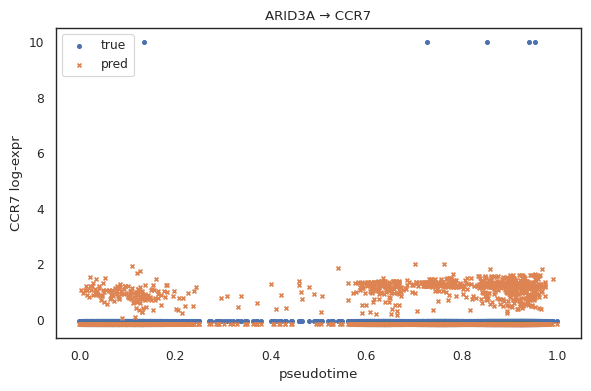

In [49]:
# --- 1. per-gene mean / std computed on the SAME matrix you used for training
X_raw   = adata[:, selected_genes].X.toarray().astype(float)      # cells × genes
mu      = X_raw.mean(axis=0)                                      # shape (N_genes,)
sigma   = X_raw.std(axis=0) + 1e-6

# --- 2. run the model & bring predictions back to log-count scale
pred_dst = []
with torch.no_grad():
    for i in range(len(dataset)):
        z = model(dataset[i].to(device)).squeeze().cpu().numpy()  # z-scores
        x_hat = z * sigma + mu                                    # de-standardise
        pred_dst.append(x_hat[dst])                               # gene ‘dst’

pred_dst = np.array(pred_dst)
true_dst = adata[:, dst_gene].X.toarray().ravel()                 # unchanged

# --- 3. plot
plt.figure(figsize=(6,4))
plt.scatter(tvec, true_dst, s=8, label="true")
plt.scatter(tvec, pred_dst, s=8, marker="x", label="pred")
plt.xlabel("pseudotime"); plt.ylabel(f"{dst_gene} log-expr")
plt.title(f"{src_gene} → {dst_gene}")
plt.legend(); plt.tight_layout(); plt.show()



In [63]:
def plot_edge_expression(src_gene: str, dst_gene: str):
    """
    Scatter of true vs. model-predicted expression of <dst_gene>
    along pseudotime, for the putative edge <src_gene> → <dst_gene>.
    """
    # ── indices (raises ValueError if gene not present) ───────────────────
    src = gene_list.index(src_gene)
    dst = gene_list.index(dst_gene)

    # ── ground-truth target expression (log-scale) ────────────────────────
    true_dst = adata[:, dst_gene].X.toarray().ravel()

    # ── de-standardise model predictions to log space ─────────────────────
    mu    = adata[:, selected_genes].X.toarray().mean(axis=0)
    sigma = adata[:, selected_genes].X.toarray().std(axis=0) + 1e-6

    pred_dst = []
    model.eval()
    with torch.no_grad():
        for cell in dataset:
            z = model(cell.to(device)).squeeze().cpu().numpy()
            x_hat = z * sigma + mu              # back to log space
            pred_dst.append(x_hat[dst])
    pred_dst = np.array(pred_dst)

    # ── plot ──────────────────────────────────────────────────────────────
    plt.figure(figsize=(6,4))
    plt.scatter(tvec, true_dst, s=8, alpha=.7, label="true")
    plt.scatter(tvec, pred_dst, s=8, marker="x", alpha=.7, label="pred")
    plt.xlabel("pseudotime"); plt.ylabel(f"{dst_gene}  log-expr")
    plt.title(f"{src_gene} → {dst_gene}")
    plt.legend(); plt.tight_layout(); plt.show()

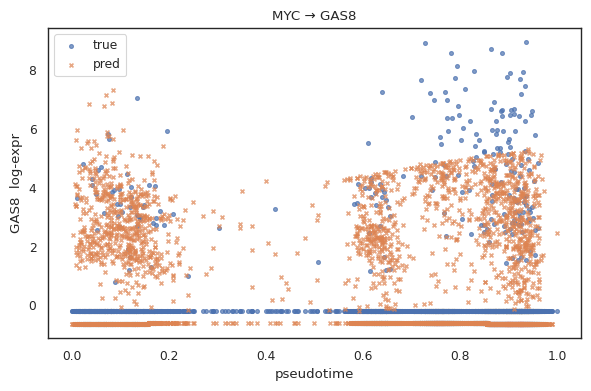

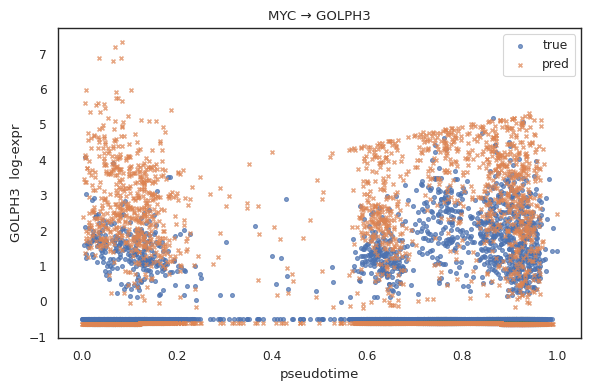

In [64]:
plot_edge_expression("MYC",  "GAS8")
plot_edge_expression("MYC",  "GOLPH3")


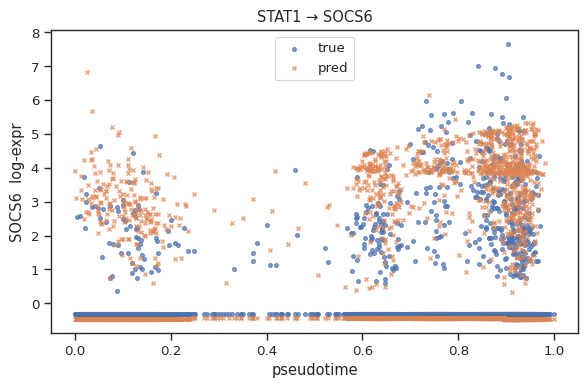

In [67]:
plot_edge_expression("STAT1",  "SOCS6")


In [56]:

# 2. pre-compute per-gene statistics
expr   = np.asarray(adata.X)         # works for dense or sparse via np.asarray
var_g  = expr.var(axis=0)            # variance per gene
frac_g = (expr > 0).mean(axis=0)     # fraction of cells with non-zero expr
# rank edges by attention score
top_edges = np.argsort(-edge_scores)[:500]

# expression matrix (dense)
expr   = np.asarray(adata.X)
var_g  = expr.var(axis=0)
frac_g = (expr > 0).mean(axis=0)

keep = []
for e in top_edges:
    src, dst = edge_index[:, e]
    if var_g[dst] > np.percentile(var_g, 75) and frac_g[dst] > 0.05:
        keep.append((src, dst, edge_scores[e]))
    if len(keep) == 10:
        break

print("Suggested TF → target pairs:")
for src, dst, sc in keep:
    print(f"{gene_list[src]}  →  {gene_list[dst]}   (score {sc:.3f})")



Suggested TF → target pairs:
MYC  →  GAS8   (score 1.000)
MYC  →  GOLPH3   (score 1.000)
PRDM14  →  CACNA1G   (score 1.000)
MYC  →  CLUH   (score 1.000)
MYC  →  CLUL1   (score 1.000)
STAT1  →  SOCS6   (score 1.000)
ETS1  →  CHUK   (score 1.000)
STAT1  →  IDO1   (score 1.000)
STAT1  →  IFNLR1   (score 1.000)
ETS1  →  GRPR   (score 1.000)


#Sanity Check

In [34]:

# ----------------------------------------------------------
# 1.  Fraction of cells with 1 ≤ MSE ≤ 3
# ----------------------------------------------------------
cell_mse_arr = np.asarray(cell_mse)
in_range = ((cell_mse_arr >= 1) & (cell_mse_arr <= 3)).mean()
print(f"∎ Cells with 1 ≤ MSE ≤ 3  :  {in_range*100:.1f}%")

# ----------------------------------------------------------
# 2.  Mean vs. median
# ----------------------------------------------------------
mean_mse   = cell_mse_arr.mean()
median_mse = np.median(cell_mse_arr)
print(f"∎ Mean MSE    = {mean_mse:.3f}")
print(f"∎ Median MSE  = {median_mse:.3f}")

# ----------------------------------------------------------
# 3.  Correlation of error with pseudotime
# ----------------------------------------------------------
rho, p = st.spearmanr(tvec, cell_mse_arr)
print(f"∎ Spearman ρ  = {rho:.3f}   (p = {p:.2e})")

# ----------------------------------------------------------
# 4.  Baseline MSE from mean-gene predictor
# ----------------------------------------------------------
#  (vector of gene means, broadcast across all cells)
gene_mean = torch.tensor(adata.X.mean(axis=0))
baseline_mse = torch.mean((torch.tensor(adata.X) - gene_mean)**2).item()
rmse_model   = np.sqrt(mean_mse)
rmse_baseline= np.sqrt(baseline_mse)
impr = (baseline_mse - mean_mse) / baseline_mse
print(f"∎ Baseline MSE         = {baseline_mse:.3f}")
print(f"  → Baseline RMSE      = {rmse_baseline:.3f}")
print(f"∎ Model   RMSE         = {rmse_model:.3f}")
print(f"∎ Relative improvement = {impr*100:.1f}%")


∎ Cells with 1 ≤ MSE ≤ 3  :  79.0%
∎ Mean MSE    = 1.992
∎ Median MSE  = 1.733
∎ Spearman ρ  = 0.165   (p = 2.40e-32)
∎ Baseline MSE         = 0.864
  → Baseline RMSE      = 0.930
∎ Model   RMSE         = 1.411
∎ Relative improvement = -130.5%


In [35]:
# ── verification cell for Figure 12  ───────────────────────────────────

# 1.  Build label vector: 1 = DoRothEA confidence A/B, 0 = otherwise
if 'doro' not in globals():
    doro = pd.read_csv("dorothea_hs.csv")

strong_pairs = {(gene_to_idx[tf], gene_to_idx[tg])
                for tf, tg, conf in zip(doro.tf, doro.target, doro.confidence)
                if conf in ["A", "B"] and tf in gene_to_idx and tg in gene_to_idx}

y_true_strong = np.array([
    1 if (edge_index[0,i].item(), edge_index[1,i].item()) in strong_pairs else 0
    for i in range(edge_index.size(1))
])

print("Label balance  –  positives:", y_true_strong.sum(),
      "negatives:", (1 - y_true_strong).sum())

# 2.  Sort edges by attention (descending)
order = np.argsort(-edge_scores)

# 3.  Precision@K for the same K values used in the plot
K_list = [25, 50, 100, 200, 500]
prec_vals = []

for K in K_list:
    hits = y_true_strong[order[:K]].sum()
    prec = hits / K
    prec_vals.append(prec)
    print(f"Precision@{K:<3d} = {hits}/{K}  ({prec:.3f})")

# 4.  Sanity check: expected random precision baseline
baseline = y_true_strong.mean()
print(f"\nRandom-baseline precision (catalogue prior) = {baseline:.3f}")


Label balance  –  positives: 2848 negatives: 832
Precision@25  = 23/25  (0.920)
Precision@50  = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)

Random-baseline precision (catalogue prior) = 0.774


In [36]:
# ─── VERIFY EDGE-RE-WEIGHTING SCATTER ──────────────────────────────────

# 1.  Recompute mean attention for early and late bins
mid = np.median(tvec)
early_idx = np.where(tvec <= mid)[0]
late_idx  = np.where(tvec >  mid)[0]

def mean_attention(ix):
    s = torch.zeros(edge_index.size(1))
    with torch.no_grad():
        for i in ix:
            b = dataset[i].to(device)
            _, a = model(b, return_attn=True)
            s += a.squeeze().cpu()
    return (s / len(ix)).numpy()

att_early = mean_attention(early_idx)
att_late  = mean_attention(late_idx)

# 2.  Spearman correlation
rho, p = st.spearmanr(att_early, att_late)
print(f"Spearman ρ = {rho:.4f}   p = {p:.2e}")

# 3.  Identify top-5 edges
delta = np.abs(att_late - att_early)
top5  = delta.argsort()[-5:][::-1]          # largest first

print("\nTop-5 dynamic edges (early → late change):")
for idx in top5:
    tf  = gene_list[ edge_index[0,idx] ]
    tgt = gene_list[ edge_index[1,idx] ]
    print(f"{tf:>8s} → {tgt:<8s}   Δ = {delta[idx]:.3f} "
          f"(early={att_early[idx]:.3f}, late={att_late[idx]:.3f})")


Spearman ρ = 0.9775   p = 0.00e+00

Top-5 dynamic edges (early → late change):
  POU5F1 → GALNT10    Δ = 0.214 (early=0.382, late=0.596)
   GATA3 → GALNT10    Δ = 0.214 (early=0.618, late=0.404)
  POU5F1 → CLASP2     Δ = 0.185 (early=0.400, late=0.585)
    E2F1 → CLASP2     Δ = 0.185 (early=0.600, late=0.415)
  POU5F1 → COBL       Δ = 0.179 (early=0.248, late=0.426)


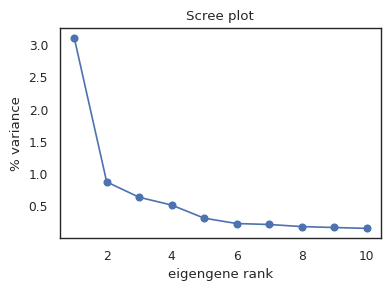

In [42]:
# ╭────────────────────  Eigengene / eigenarray analysis  ───────────────────╮

# ---------------- 1. build expression matrix for selected genes ------------
X = adata[:, selected_genes].X.toarray().astype(float)   # shape: cells × genes
# z-score each gene so SVD focuses on co-variation, not scale
X -= X.mean(axis=0, keepdims=True)
X /= X.std(axis=0, keepdims=True) + 1e-6                 # prevent div/0

# ---------------- 2. full SVD  (U = eigenarrays, V = eigengenes) -----------
U, S, Vt = svd(X, full_matrices=False)    # U: (cells,k)  Vt: (k,genes)
eigarrays  = U            # per-cell coordinates
eigengenes = Vt.T         # per-gene loadings
var_frac   = (S**2) / (S**2).sum()

# ---------------- 3. scree plot of variance explained ----------------------
plt.figure(figsize=(4,3))
plt.plot(np.arange(1,11), var_frac[:10]*100,"o-")
plt.ylabel("% variance"); plt.xlabel("eigengene rank")
plt.title("Scree plot"); plt.tight_layout(); plt.show()


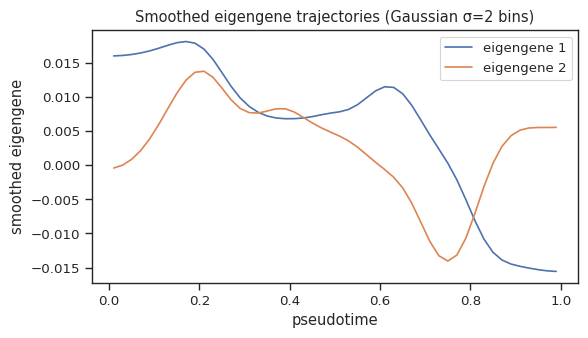

In [38]:
# ╔════════════ 1.  bin cells and smooth eigengene trajectories ════════════╗

# --- expression matrix for selected genes (z-scored) ----------------------
X = adata[:, selected_genes].X.toarray().astype(float)
X = (X - X.mean(0)) / (X.std(0) + 1e-6)

# --- full SVD -------------------------------------------------------------
U, S, Vt = svd(X, full_matrices=False)
eigarrays  = U                          # cells × components
eigengenes = Vt.T                       # genes × components

# --- bin cells along pseudotime ------------------------------------------
n_bins = 50
bins   = np.linspace(tvec.min(), tvec.max(), n_bins+1)
bin_id = np.digitize(tvec, bins) - 1              # 0 … n_bins-1

traj = []
for c in range(2):                                 # first two eigengenes
    series = [eigarrays[bin_id == b, c].mean() for b in range(n_bins)]
    traj.append(gaussian_filter1d(series, sigma=2))   # smooth
traj = np.vstack(traj)              # shape 2 × n_bins
ptime = 0.5*(bins[1:] + bins[:-1])  # bin centres

# --- plot smoothed trajectories ------------------------------------------
plt.figure(figsize=(6,3.5))
plt.plot(ptime, traj[0], label="eigengene 1")
plt.plot(ptime, traj[1], label="eigengene 2")
plt.xlabel("pseudotime"); plt.ylabel("smoothed eigengene")
plt.title("Smoothed eigengene trajectories (Gaussian σ=2 bins)")
plt.legend(); plt.tight_layout(); plt.show()
# ╚═════════════════════════════════════════════════════════════════════════╝


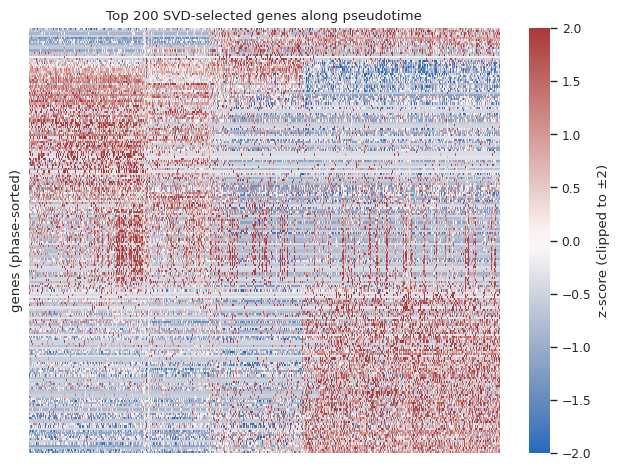

In [62]:
# ╔════════════ 2.  heat-map of top-variance genes (phase-sorted) ══════════╗

# --- pick 200 genes with largest |loading| on eig1 or eig2 -----------------
load_mag = np.sqrt(eigengenes[:,0]**2 + eigengenes[:,1]**2)
top_idx   = np.argsort(-load_mag)[:200]

# --- phase (angle) in the eig1–eig2 plane for sorting ---------------------
phase = np.arctan2(eigengenes[top_idx,1], eigengenes[top_idx,0])
order = top_idx[np.argsort(phase)]

# --- expression matrix: cells ordered by pseudotime, genes by phase -------
X_ord = X[np.argsort(tvec)][:, order]           # cells × selected genes
# clip & rescale for colour range
X_clip = np.clip(X_ord, -2, 2)

# --- clustered heat-map ---------------------------------------------------
sns.heatmap(
    X_clip.T,
    cmap="vlag", center=0,
    xticklabels=False,          # hide pseudotime cell labels (kept as before)
    yticklabels=False,          # ← hide gene names
    cbar_kws=dict(label="z-score (clipped to ±2)")
)
plt.ylabel("genes (phase-sorted)")
plt.title("Top 200 SVD-selected genes along pseudotime")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


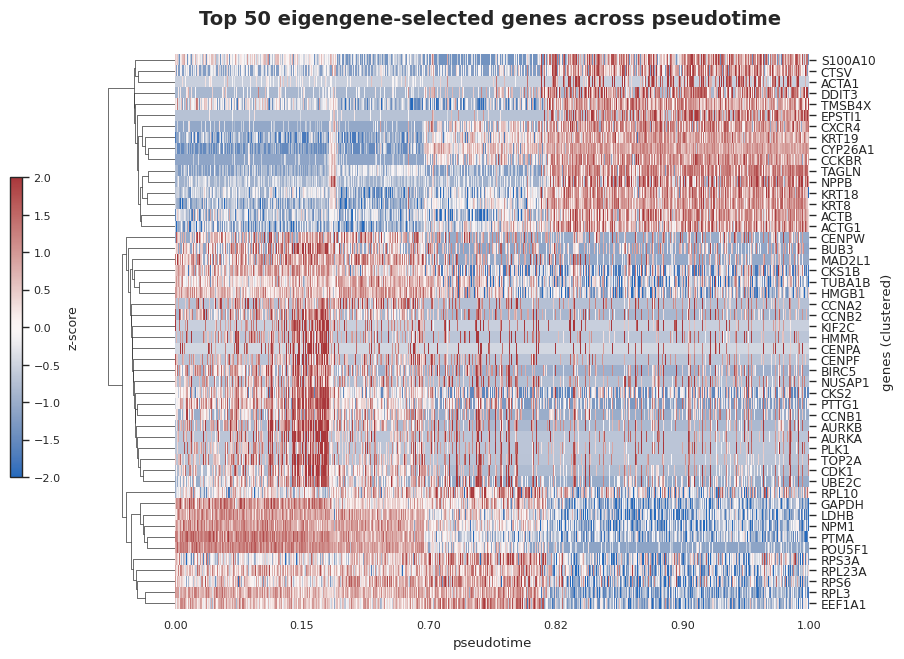

In [61]:


# ────────────────── parameters ──────────────────
top_n = 50                       # number of genes to display
z_clip = 2                       # colour-bar limit
cmap   = "vlag"                  # red–white–blue palette

# ────────────────── 1. choose top-loading genes ──────────────────
load_mag  = np.sqrt(eigengenes[:,0]**2 + eigengenes[:,1]**2)      # |eig1 & eig2|
top_idx   = np.argsort(-load_mag)[:top_n]
gene_lbls = [selected_genes[i] for i in top_idx]

# ────────────────── 2. expression matrix (cells sorted by pseudotime) ─────
X_top = X[np.argsort(tvec)][:, top_idx]                           # cells × genes
X_top = (X_top - X_top.mean(0)) / (X_top.std(0) + 1e-6)          # z-score rows
X_top = np.clip(X_top, -z_clip, z_clip)                          # colour range
expr_df = pd.DataFrame(X_top, columns=gene_lbls)

# ────────────────── 3. hierarchical clustering of genes ───────────────────
Z = linkage(expr_df.T, method="average", metric="correlation")
row_order = leaves_list(Z)
expr_df = expr_df.iloc[:, row_order]                 # re-order columns

# ────────────────── 4. cluster-heat-map ───────────────────────────────────

g = sns.clustermap(expr_df.T,
                   cmap=cmap, center=0,
                   row_cluster=True, col_cluster=False,
                   yticklabels=True, xticklabels=False,
                   figsize=(8,6),
                   dendrogram_ratio=(0.10, 0.02),
                   cbar_kws=dict(label=f"z-score (±{z_clip})"))


g.cax.set_visible(False)


cbar_ax = g.fig.add_axes([-0.10, 0.25, 0.015, 0.5])

norm = plt.Normalize(vmin=-z_clip, vmax=z_clip)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = g.fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=8)
cb.set_label("z-score", fontsize=9)


t_sorted = np.sort(tvec)
ticks    = np.linspace(0, len(t_sorted)-1, 6, dtype=int)
g.ax_heatmap.set_xticks(ticks + 0.5)
g.ax_heatmap.set_xticklabels([f"{t_sorted[i]:.2f}" for i in ticks],
                             rotation=0, fontsize=8)
g.ax_heatmap.set_xlabel("pseudotime")


g.ax_heatmap.set_ylabel("genes (clustered)")
g.fig.suptitle(f"Top {top_n} eigengene-selected genes across pseudotime",
               y=1.03, fontsize=14, fontweight="bold")

plt.show()



In [41]:
# eigengene 1
eig1_rank = pd.Series(eigengenes[:,0], index=selected_genes).sort_values(ascending=False)
print("\nTop 15 genes positively on eigengene 1:")
print(eig1_rank.head(15))

print("\nTop 15 genes negatively on eigengene 1:")
print(eig1_rank.tail(15))

# eigengene 2
eig2_rank = pd.Series(eigengenes[:,1], index=selected_genes).sort_values(ascending=False)
print("\nTop 15 genes positively on eigengene 2:")
print(eig2_rank.head(15))

print("\nTop 15 genes negatively on eigengene 2:")
print(eig2_rank.tail(15))



Top 15 genes loading positively on eigengene 1:
POU5F1    0.121244
PTMA      0.114061
NPM1      0.107861
RPL3      0.104922
GAPDH     0.103071
LDHB      0.102719
HSPD1     0.090539
PGK1      0.088322
TPI1      0.085033
EEF1A1    0.084872
FDFT1     0.083839
LDHA      0.083729
MT1X      0.080307
HMGB1     0.079303
CD9       0.079206
dtype: float64

Top 15 genes loading negatively on eigengene 1:
IFITM3    -0.085548
HERPUD1   -0.087946
CTSV      -0.090908
DDIT3     -0.091750
EPSTI1    -0.093492
CD63      -0.097039
NPPB      -0.097380
KRT18     -0.098036
ACTG1     -0.100303
TAGLN     -0.107062
CXCR4     -0.109783
KRT19     -0.113398
KRT8      -0.113973
CCKBR     -0.114510
CYP26A1   -0.121623
dtype: float64

Top 15 genes loading positively on eigengene 2:
CKS2       0.146438
CDK1       0.134035
UBE2C      0.133836
CKS1B      0.131242
S100A10    0.128023
PLK1       0.127257
CCNB1      0.125690
AURKB      0.123051
PTTG1      0.119442
AURKA      0.114919
CCNA2      0.113168
TOP2A      0.11105